In [17]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.integrate import quad
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from IPython.display import HTML 
import warnings
warnings.filterwarnings('ignore')


Waveform: I needed to uniformize dt!

n_cycle. Do I need the kepler frequency or the GW frequency?

**3^rd order Hermite algorithm: error scales as dt^3**


$$G = 1$$
$$\textbf{f}_i=\sum_{j\neq i} \frac{m_im_j}{|\textbf{r}_{ij}|^3}\textbf{r}_{ij}$$

$$\textbf{x}_{i+1}=\textbf{x}_i+\textbf{v}_idt+\frac{1}{2}\textbf{a}_idt^2+\frac{1}{3!}\textbf{J}_idt^3$$

$$\textbf{v}_{i+1}=\textbf{v}_i+\textbf{a}_idt+\frac{1}{2}\textbf{J}_idt^2$$

The jerk can be evaluated knowing the position and the velocity vector only: 

$$\textbf{a}_i=\sum_{j\neq i} \frac{m_j}{|\textbf{r}_{ij}|^3}\textbf{r}_{ij}$$
$$\textbf{J}_i=\frac{d}{dt}\textbf{a}_i=\sum_{j\neq i}m_j\left( \frac{\textbf{v}_{ij}}{|\textbf{r}_{ij}|^3}-3\frac{\textbf{r}_{ij}}{|\textbf{r}_{ij}|^4}\frac{d}{dt}|\textbf{r}_{ij}|\right)$$

but $|\textbf{r}_{ij}|=\sqrt{\textbf{r}_{ij}\cdot \textbf{r}_{ij}}$ thus: 

$$\textbf{J}_i=\sum_{j\neq i}\frac{m_j}{|\textbf{r}_{ij}|^3}\left(\textbf{v}_{ij}-3\frac{\textbf{r}_{ij}}{|\textbf{r}_{ij}|}\frac{2(\textbf{v}_{ij}\cdot \textbf{r}_{ij})}{2|\textbf{r}_{ij}|}\right)=\sum_{j\neq i}\frac{m_j}{|\textbf{r}_{ij}|^3}\left(\textbf{v}_{ij}-3\frac{\textbf{r}_{ij}(\textbf{v}_{ij}\cdot \textbf{r}_{ij})}{|\textbf{r}_{ij}|^2}\right)$$

PREDICTOR evaluates $\textbf{a}_i$ and $\textbf{J}_i$ from initial position and velocity and computes $\textbf{x}_{i+1}$ and $\textbf{v}_{i+1}$ to the order 2. 

Adaptive $dt$. AT each step the algorithm computes $|\frac{\textbf{x}_{i}}{\textbf{v}_{i}}|$ and $|\frac{\textbf{x}_{i}}{\textbf{a}_{i}}|^{\frac{1}{2}}$, which are times. Then it takes the minimum between this two and multyplies it by an accuracy parameter $d\ll 1$. A good choice is $d=0.03$.

**INTERNAL UNITS**

$G_{iu}$ and $c_{iu}$ are set equal to 1. We are free to express mass and velocity in arbitrary units, as far asdistances and times are consistent. In order to see that, notice that $\frac{GM}{rv^2}$ is adimensional. 

$$\frac{M_{iu}}{r_{iu}v_{iu}^2}=\frac{G_{cgs}M_{cgs}}{r_{cgs}v_{cgs}^2}$$

$$\frac{1}{r_{iu}}=\frac{GM_\odot}{r_{cgs}c^2}$$

Once we know distance in i.u., time is derived from $t=x/c$


In [1]:
G = 6.67259 * 10**-8 #G in cgs
c = 2.99 * 10**10 #cm/s
M_sun = 1.9891 * 10**33 #solar mass in g
R_sun = 6.9598 * 10**10 #solar radius in cm 
M_earth = 5.976 * 10**27 #earth mass in g
R_earth = 6.378 * 10**8 #earth radius in cm
ly = 9.463 * 10**17 #light year in cm
parsec = 3.086 * 10**18 #parsec in cm
AU = 1.496 * 10**13 #astronomical unit in cm
km = 1.e5
hour = 3600
day = 86400
yr = 3.156*10**7

In [2]:
# G = c = 1
# mass in M_sun units

def distance_IU(r_cgs):
    return r_cgs*c**2/(G*M_sun)

def time_IU(t_cgs):
    return t_cgs*c*distance_IU(1)/1

In [3]:
s_IU = time_IU(1)
hour_IU = time_IU(3600)
day_IU = time_IU(86400)
yr_IU = time_IU(3.156*10**7)

km_IU = distance_IU(km)
R_sun_IU = distance_IU(R_sun)
AU_IU = distance_IU(AU)
parsec_IU = distance_IU(parsec)

In [4]:


#JUST CIRCULAR OR AVERAGE FREQUENCY. NOT ISTANTANEOUS FREQUENCY!
def frequency_kepler(M,r):
    return 1/(2*np.pi) * np.sqrt(M/r**3)

def period_kepler(M,a):
    return 2*np.pi * np.sqrt(a**3/M)

def v_circ(M,r):
    return np.sqrt(M/r)

def r_isco(M):
    return 6*M

def f_isco(M):
    r = r_isco(M)
    return frequency_kepler(M,r)



In [5]:
def double_dot_qmm(M1,M2,r1,v1,a1,r2,v2,a2):
    double_dot_q = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            if i == j:
                double_dot_q[i][j] = (M1*(2*v1[i]**2 + 2*r1[i]*a1[j]) 
                    + M2*(2*v2[i]**2 + 2*r1[i]*a1[j]))
            else:
                double_dot_q[i][j] = (M1*(a1[i]*r1[j] + 2*v1[i]*v1[j] + a1[i]*r1[j])  
                    + M2*(a2[i]*r2[j] + 2*v2[i]*v2[j] + a2[i]*r2[j])) 
    return double_dot_q


def triple_dot_qmm(M1,M2,r1,v1,a1,J1,r2,v2,a2,J2):
    triple_dot_q = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            if i == j:
                triple_dot_q[i][j] = (M1*(6*v1[i]*a1[j] + 2*r1[i]*J1[j]) 
                    + M2*(6*v2[i]*a2[j] + 2*r2[i]*J2[j])) 
            else:
                triple_dot_q[i][j] = (M1*(J1[i]*r1[j] + 3*a1[i]*v1[j] + 3*a1[j]*v1[i] + J1[j]*r1[i])
                    + M2*(J2[i]*r2[j] + 3*a2[i]*v2[j] + 3*a2[j]*v2[i] + J2[j]*r2[i]))
    return triple_dot_q

In [6]:
# Function to find a new orthonormal basis (e1_prime, e2_prime) in the plane perpendicular to k
def construct_transverse_basis(k):
    # Find a vector not collinear with k (arbitrary choice of [1, 0, 0] or [0, 1, 0])
    if np.allclose(k, [1, 0, 0]):
        v = np.array([0, 1, 0])
    else:
        v = np.array([1, 0, 0])
    
    # First orthonormal vector e1_prime (perpendicular to k)
    e1_prime = np.cross(k, v)
    e1_prime /= np.linalg.norm(e1_prime)
    
    # Second orthonormal vector e2_prime (also in the transverse plane)
    e2_prime = np.cross(k, e1_prime)
    e2_prime /= np.linalg.norm(e2_prime)
    
    return e1_prime, e2_prime   


# Function to rotate the TT matrix into the new basis defined by e1_prime and e2_prime
def rotate_to_new_frame(A, e1_prime, e2_prime):
    # Construct the rotation matrix from the new basis
    R = np.array([e1_prime, e2_prime, np.cross(e1_prime, e2_prime)]).T
    
    # Rotate the matrix A using the rotation matrix
    A_rotated = R.T @ A @ R
    
    return A_rotated

def TT_projector(v,q):  
    P = [
        [1 - v[0]**2, -v[0]*v[1], -v[0]*v[2]],
        [-v[1]*v[0], 1 - v[1]**2, -v[1]*v[2]],
        [-v[2]*v[0], -v[2]*v[1], 1 - v[2]**2]
    ]
    q_tt = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    q_tt[i][j] += (P[i][k]*P[j][l]-1/2*P[i][j]*P[k][l])*q[k][l]
    return q_tt

In [7]:

def polarized_strains(M1,M2,r1,v1,a1,r2,v2,a2,n_obs,d):
    
    ddot_q = double_dot_qmm(M1,M2,r1,v1,a1,r2,v2,a2)
    ddot_q_tt = TT_projector(n_obs, ddot_q)             
        
    #Construct a transverse basis (e1_prime, e2_prime) orthogonal to k
    e1_prime, e2_prime = construct_transverse_basis(n_obs)

    #Rotate the matrix A into the new frame
    ddot_q_pol_basis = rotate_to_new_frame(ddot_q_tt, e1_prime, e2_prime)

    # Extract the 2x2 part from the rotated matrix (upper-left 2x2 block)
    ddot_q_pol_basis = ddot_q_pol_basis[:2, :2]
    h_plus = 2/d * ddot_q_pol_basis[0][0]  
    h_cross = 2/d * ddot_q_pol_basis[0][1]  

    return h_plus, h_cross


def step_slow_motion(M1,M2,r1,r2,v1,v2,n_obs,d):     #check for slow motion????

    r = np.linalg.norm(r1 - r2)
   
    a1 = M2/r**3 * (r2-r1)
    a2 = M1/r**3 * (r1-r2)
    J1 = M2/r**3 * (v2-v1-3*(r2 - r1)*np.dot(v2-v1,r2-r1)/r**2)
    J2 = M1/r**3 * (v1-v2-3*(r1 - r2)*np.dot(v1-v2,r1-r2)/r**2)

    h_plus, h_cross = polarized_strains(M1,M2,r1,v1,a1,r2,v2,a2,n_obs,d)    
   
    ## GW luminosity ##        
    tdot_q = triple_dot_qmm(M1,M2,r1,v1,a1,J2,r2,v2,a2,J2)                  
    L_gw = 1/5 * np.sum(tdot_q**2) 

    #step
    v = np.linalg.norm(v1 - v2)
    a = np.linalg.norm(a1 - a2)
    dt = 0.01*min(r/v,np.sqrt(r/a))  
     
    r1 += v1*dt + 1/2 * a1 * dt**2 + 1/6 * J1 * dt**3  -  (r1-r2)/r * 2*r**2/(M1*M2) * L_gw * dt  
    r2 += v2*dt + 1/2 * a2 * dt**2 + 1/6 * J2 * dt**3  -  (r2-r1)/r * 2*r**2/(M1*M2) * L_gw * dt
    v1 += a1 * dt + 1/2 * J1 * dt**2 
    v2 += a2 * dt + 1/2 * J2 * dt**2   

    return r1,r2,v1,v2,h_plus,h_cross,dt 
    


In [8]:
#for zero eccentricity binaries

def extract_frequencies(time, signal):
    # Find peaks (or zero-crossings)
    peaks, _ = find_peaks(signal)
    peak_times = time[peaks]
    
    # Compute instantaneous frequency as the inverse of time between peaks
    periods = np.diff(peak_times)
    frequencies = 1 / periods
    
    # Assign the frequencies to the midpoints between the peaks
    freq_times = (peak_times[:-1] + peak_times[1:]) / 2
    
    return freq_times, frequencies
    

In [9]:
#M1 and M2 in solar mass, a in cgs, d in parsec

class Binary:
    def __init__(self,M1,M2,a,e,d=1.e3,i=0,peri_arg=0,sky_loc=[0,0,0]):
        
        self.M1, self.M2 = M1, M2                                # iu: 1 M_sun
        self.M = self.M1 + self.M2
        self.mu = self.M1*self.M2/self.M
        self.a = distance_IU(a)                                  # iu
        self.e = e                                               # adimensional
        self.r_peri = self.a*(1-self.e)                           
        self.r_apo = self.a*(1+self.e)  
        self.f_k_init = frequency_kepler(self.M,self.a)               # iu  AVERAGE FREQUENCY OF FIRST ORBIT
        self.P = period_kepler(self.M,self.a)                         # iu 
        self.E = -self.M*self.mu/(2*self.a)                      #iu
        self.L = self.mu*np.sqrt(self.M*self.a*(1-self.e**2))    #iu angular momentum

        ## UNITS ##
        
        if a <= 1.e-2*R_sun:
            self.d_factor = km_IU
            self.d_label = "[km]"; self.d_units = "km"
        elif 1.e-2*R_sun < a <= 1.e2 * R_sun:
            self.d_factor = R_sun_IU
            self.d_label = "[$R_\odot$]"; self.d_units = "R_sun"
        elif 1.e2*R_sun <= a < 1.e3*AU:
            self.d_factor = AU_IU 
            self.d_label = "[AU]"; self.d_units = "AU"  
        else:
            self.d_factor = parsec_IU
            self.d_label = "[parsec]"; self.d_units = "parsec"  

        
        
        self.t_factor = yr_IU
        self.t_label = "[years]"; self.t_units = "years"
        if day_IU < self.P < yr_IU: 
            self.t_factor = day_IU
            self.t_label = "[days]"; self.t_units = "days"
        elif hour_IU < self.P < day_IU: 
            self.t_factor = hour_IU
            self.t_label = "[hours]"; self.t_units = "hours"
        elif self.P < hour_IU: 
            self.t_factor = s_IU
            self.t_label = "[s]"; self.t_units = "s"


        self.R_isco = r_isco(self.M)
        self.f_isco = f_isco(self.M)
        self.f_ringdown = 3*self.f_isco
        self.M_chirp = self.M1**(3/5)*self.M2**(3/5)/self.M**(1/5)
        self.F_e = (1-self.e)**(-7/2) * (1+73/24*self.e**2+37/96*self.e**4)
        self.t_c = 5/256 * self.a**4 / (self.mu*self.M**2) / self.F_e 

        self.d = d*parsec_IU    #distance in internal units
        self.i = i
        self.peri_arg = peri_arg
        self.n_obs = np.array([np.sin(self.i)*np.cos(self.peri_arg),np.sin(self.i)*np.sin(self.peri_arg),np.cos(self.i)])
        self.n_obs[np.isclose(self.n_obs, 0)] = 0 
        self.theta, self.phi, self.psi = sky_loc
 

        print(f"r_periastron (minimum separation): {self.r_peri / self.d_factor:.2f} {self.d_units}")
        print(f"r_apoastron (maximum separation): {self.r_apo / self.d_factor:.2f} {self.d_units}")
        print(f"Orbital period: {self.P / self.t_factor:.2f} {self.t_units}")
        print(f"f kepler: {self.f_k_init*s_IU:.2e} Hz")
        print(f"R ISCO: {self.R_isco / self.d_factor:.2e} {self.d_units}")
        print(f"f ISCO: {self.f_isco * s_IU:.2e} Hz")
        print(f"Chirp mass: {self.M_chirp:.2f} M_sun")
        print(f"Eccentricity factor F_e: {self.F_e:.2e}")
        print(f"Coalescence time: {self.t_c/self.P:.2e} periods: {self.t_c / yr_IU:.2e} years ({self.t_c / s_IU:.2e} s)")



    
    def initial_conditions(self):
        #points initially located at periastron
        r1 = np.array([self.r_peri,0,0])*self.M2/self.M
        r2 = -np.array([self.r_peri,0,0])*self.M1/self.M
        
        #velocity at periastron is perpendicular to displacement vector (r_dot=0)
        #attention: Omea must me computed from angular momentum. We can't just plug r_peri in kepler formula
        Omega_peri = self.L/(self.mu*self.r_peri**2)
        v_peri = self.r_peri*Omega_peri
        
        v1 = self.M2/self.M * v_peri * np.array([0,1,0])  
        v2 = self.M1/self.M * v_peri * np.array([0,-1,0])    
        
        #computes initial strains 
        r = np.linalg.norm(r1 - r2)
        a1 = self.M2/r**3 * (r2-r1)
        a2 = self.M1/r**3 * (r1-r2)
        h_plus, h_cross = polarized_strains(self.M1,self.M2,r1,v1,a1,r2,v2,a2,self.n_obs,self.d) 
        
        return r1,r2,v1,v2,h_plus,h_cross

    
    #tstop in cgs    
    def evolve(self,tstop,pbar,save_ram):
        tstop = time_IU(tstop)                                      #converted in iu
        if pbar:
            Pbar = tqdm(total=tstop, desc="Evolution Progress", unit="s",leave=True)
        
        r1,r2,v1,v2,h_plus,h_cross = self.initial_conditions()
        R1, R2 = [np.copy(r1)], [np.copy(r2)]
        r = [np.linalg.norm(r1-r2)]                      
        h_plus_arr, h_cross_arr = [h_plus], [h_cross]  
        t = [0]
        
        r_last = r[0]
        r_ringdown = self.R_isco / 3**(2/3)    #radius at which frequency is equal to 3 f_isco (the ringdown frequency)
        
        while t[-1] < tstop and r_last > r_ringdown: 
            r1,r2,v1,v2,h_plus,h_cross,dt = step_slow_motion(self.M1,self.M2,R1[-1],R2[-1],v1,v2,self.n_obs,self.d)
            r_last = np.linalg.norm(r1-r2)
            h_plus_arr.append(h_plus)            
            h_cross_arr.append(h_cross)   
            t.append(t[-1]+dt)
            if not save_ram:     
                R1.append(np.copy(r1))
                R2.append(np.copy(r2))
                r.append(r_last)
            if pbar and len(t) % 100 == 0:
                Pbar.update(dt*100)

        if r_last <= r_ringdown:
            t_merger = t[-1]
            dt = min(np.diff(t))
            
            #print("Merger after: %.2e s (%.2e yrs)" %(t_merger/s_IU, t_merger/yr_IU))
        
            A_plus = h_plus_arr[-1]
            A_cross = h_cross_arr[-1]
            tau_22 = 55*(self.M/1.e6)*s_IU
            # phi_0_plus 
            #phi_0_cross
    
            ringdown_plus = lambda t_val: A_plus*np.exp(-t_val/tau_22)*np.cos(2*np.pi*self.f_ringdown*t_val)
            ringdown_cross = lambda t_val: A_cross*np.exp(-t_val/tau_22)*np.cos(2*np.pi*self.f_ringdown*t_val)

            t_chirp_end = t_merger + 30*tau_22   #exp factor is 10e-10
            
            while t[-1] < tstop and t[-1] < t_chirp_end:
                
                h_plus_arr.append(ringdown_plus(t[-1]-t_merger))
                h_cross_arr.append(ringdown_cross(t[-1]-t_merger))
                t.append(t[-1]+dt)
                if not save_ram:     
                    R1.append(R1[-1])
                    R2.append(R2[-1])
                    r.append(r[-1])
                           
        if pbar: Pbar.close()

        if save_ram:
            return h_plus_arr, h_cross_arr, t
        else: 
            return R1, R2, r, h_plus_arr, h_cross_arr, t




In [23]:
# t_obs in cgs 

def signal_in_detector(binary, t_obs, pbar=False, plot=False, tstart=0,tstop=0):

    tstart = time_IU(tstart)
    tstop = time_IU(tstop)
    h_plus, h_cross, t = binary.evolve(t_obs,pbar,save_ram = True)    #takes t_obs in cgs
    h_plus = np.array(h_plus)     
    h_cross = np.array(h_cross)
    t = np.array(t) 

    theta, phi, psi = binary.theta, binary.phi, binary.psi
    F_plus = 1/2 * (1 + np.cos(theta))**2 * np.cos(2 * phi) * np.cos(2 * psi) - np.cos(theta) * np.sin(2 * phi) * np.sin(2 * psi)
    F_cross = 1/2 * (1 + np.cos(theta))**2 * np.cos(2 * phi) * np.sin(2 * psi) + np.cos(theta) * np.sin(2 * phi) * np.cos(2 * psi)
    if np.isclose(F_plus, 0): F_plus = 0 
    if np.isclose(F_cross, 0): F_cross = 0 
    
    h = h_plus * F_plus + h_cross * F_cross

    # Resample the time series data (t, h) to have equal timesteps
    dt = np.min(np.diff(t))  # smallest timestep in the original data
    t_uniform = np.arange(t[0], t[-1], dt)
    interp_func = interp1d(t, h, kind='linear', fill_value="extrapolate")  # Create an interpolation function based on the original data
    h_uniform = interp_func(t_uniform)  # Use the interpolation function to compute h at the new time points

    N = len(t_uniform)

    fft_h = np.fft.fft(h_uniform) #/ N 
    frequencies = np.fft.fftfreq(N, dt)[:N // 2]  
    h_f = np.abs(fft_h)[:N // 2] 
    frequencies = frequencies[frequencies != 0]
    h_f = h_f[1:len(frequencies) + 1]

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(f"T = {t_obs:.2e} s ({t_obs/yr:.3f} year), $\Delta f$ = {min(np.diff(frequencies)):.2e} Hz, "
                     f"$f_{{k,initial}}$ = {binary.f_k_init * s_IU:.2e} Hz, $f_{{ISCO}}$ = {binary.f_isco * s_IU:.2e} Hz, "
                     f"$\\theta$ = {theta:.2f}, $\\phi$ = {phi:.2f}, $\\psi$ = {psi:.2f}")
        
        # Time-domain plot
        ax1.set(xlim=(tstart/binary.t_factor, tstop/binary.t_factor), xlabel="t %s" %binary.t_label, ylabel="strain $h(t)$")
        ax1.plot(t/binary.t_factor, h, 'o', c='black', markersize=0.5, alpha=0.8)

        # Frequency-domain plot
        ax2.set(xlim=(frequencies[0] * s_IU, frequencies[-1] * s_IU),
                xlabel="log frequency [Hz]", ylabel="log spectral density")
        ax2.plot(frequencies * s_IU, h_f, c='red')
        ax2.set_xscale("log")
        ax2.set_yscale("log")

        plt.tight_layout()
        fig.subplots_adjust()
        plt.show()
        
    return h_uniform, t_uniform, h_f, frequencies



    
    




In [24]:
#tstop in cgs

def plot(binary,tstop,tstart=0,pbar=False):
            
    R1, R2, separation, h_plus, h_cross, t = binary.evolve(tstop,pbar,save_ram=False)

    start_idx = np.searchsorted(t, tstart,side='left')
    t = np.array(t[start_idx:])
    R1, R2 = np.array(R1[start_idx:]), np.array(R2[start_idx:])
    separation = np.array(separation[start_idx:])
    h_plus, h_cross = h_plus[start_idx:], h_cross[start_idx:]

    f_kepler = frequency_kepler(binary.M,separation)                        #iu
    t_gw, f_gw = extract_frequencies(np.array(t), np.array(h_plus))
    f_of_t = interp1d(t_gw, f_gw, kind='linear', fill_value="extrapolate")  #f_of_t = instantaneous_freq(t,h_plus)
    f_gw_fun = f_of_t(t)

    #create figure and set axes
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 3) # width_ratios=[1.3, 0.85, 0.85]
        
    # 3D Plot on the left
    ax1 = fig.add_subplot(gs[0], projection='3d')
    ax1.set_box_aspect([1, 1, 1])  # Make the 3D plot visually larger
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])


    
    ## 3d plot ##

    R1, R2, separation = R1/binary.d_factor, R2/binary.d_factor, separation/binary.d_factor   #rescale

    ax1.scatter(R1[:,0],R1[:,1],R1[:,2],s=0.1, color='blue') 
    ax1.scatter(R1[-1,0],R1[-1,1],R1[-1,2],s=5,label='%.1e $M_\odot$'%binary.M1, color='blue') 
    ax1.scatter(R2[:,0],R2[:,1],R2[:,2],s=0.1,color='red') 
    ax1.scatter(R2[-1,0],R2[-1,1],R2[-1,2],s=5,label='%.1e $M_\odot$'%binary.M2, color='red') 

    R1_max_dist = np.max(np.sqrt(R1[:, 0]**2 + R1[:, 1]**2 + R1[:, 2]**2))
    R2_max_dist = np.max(np.sqrt(R2[:, 0]**2 + R2[:, 1]**2 + R2[:, 2]**2))
    d_lim = 1.1 * max(R1_max_dist, R2_max_dist)
        
    ax1.set_xlim(-d_lim,d_lim) ; ax1.set_ylim(-d_lim,d_lim) ; ax1.set_zlim(-d_lim,d_lim)
    ax1.set_xlabel("x %s" %binary.d_label) ; ax1.ticklabel_format(style='sci', axis='both', scilimits=(0,0)) 

    ax1.quiver(0, 0, 0, (d_lim/2)*binary.n_obs[0], (d_lim/2)*binary.n_obs[1], (d_lim/2)*binary.n_obs[2], color='black', arrow_length_ratio=0.3)
    #ax1.set_facecolor('black') # alpha=0.5  
    ax1.legend() #loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.

    
    ## h_plus h_cross plot ##

    t = t/binary.t_factor
    f_kepler = f_kepler*s_IU
    f_gw_fun = f_gw_fun*s_IU
    
    ax2.plot(t,h_plus,label="$h_+$",c='purple')
    ax2.plot(t,h_cross,label="$h_\\times$",c='blue')
    
    ax2.set_xlim(t[0],t[-1])
    ax2.set_xlabel("time %s" %binary.t_label)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), borderaxespad=0.)
    
    ## separation and frequency plot ##

    # Create a second y-axis that shares the same x-axis
    ax3_ = ax3.twinx()  
    ax3.plot(t,separation, c='black',label='separation')
    #ax3_.plot(t, f_kepler, color='tab:red', label='kepler frequency', linestyle=':', alpha=0.7)
    ax3_.plot(t, f_gw_fun, color='tab:green', label='GW frequency (principal harmonic)', linestyle='-.', alpha = 0.8)
    ax3.axhline(y=binary.R_isco/binary.d_factor,linestyle=':',c='black')   #,label="$R_{ISCO}$"
    #ax3_.axhline(y=binary.f_isco*s_IU,linestyle='--',c='tab:red')        #label="$f_{ISCO}$
    ax3_.axhline(y=binary.f_ringdown*s_IU,linestyle='--',c='tab:green')   #,label="$f_{ringdown}$"

    #ax3_.text(t[-1], binary.f_isco * s_IU, "$f_{ISCO}$", color='tab:red', verticalalignment='bottom')
    ax3_.text(t[-1], binary.f_ringdown * s_IU, "$f_{ringdown}$", color='tab:green', verticalalignment='bottom')
    ax3.text(t[-1], binary.R_isco / binary.d_factor, "$R_{ISCO}$", color='black', verticalalignment='bottom')
    
    ax3.set_xlim(t[0],t[-1])
    ax3.set_ylim(0,1.5*max(separation))
    ax3.set_xlabel("time %s" %binary.t_label)
    ax3.set_ylabel("separation %s" %binary.d_label) 
    
    ax3_.set_ylabel('Frequency [Hz]') #color='tab:red' 
    ax3_.set_ylim(min(f_kepler),1.1*binary.f_ringdown*s_IU) 
    ax3_.set_yscale("log")
    
    lines, labels = ax3.get_legend_handles_labels()  # Get the handles and labels from ax2
    lines2, labels2 = ax3_.get_legend_handles_labels()  # Get the handles and labels from ax2_
    ax3_.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) #frameon=False

    plt.tight_layout()
    plt.show()


 

In [25]:
#tstop in cgs
#deltaT in cgs
#tstart in cgs

def animation(binary, tstop, deltaT, tstart=0,pbar=False):

    deltaT = time_IU(deltaT)
    
    R1, R2, separation, h_plus, h_cross, t = binary.evolve(tstop,pbar,save_ram=False)

    start_idx = np.searchsorted(t, tstart,side='left')
    t = np.array(t[start_idx:])
    R1, R2 = np.array(R1[start_idx:]), np.array(R2[start_idx:])
    separation = np.array(separation[start_idx:])
    h_plus, h_cross = h_plus[start_idx:], h_cross[start_idx:]

    R1, R2 = np.array(R1) / binary.d_factor, np.array(R2) / binary.d_factor
    separation = np.array(separation) / binary.d_factor
    t = np.array(t) / binary.t_factor
    dt = np.diff(t)

    e2_prime, e1_prime = construct_transverse_basis(binary.n_obs)

    R1_p, R2_p = [], []
    for i in range(len(R1)):
        x1_prime, y1_prime, x2_prime, y2_prime = np.dot(R1[i], e1_prime), np.dot(R1[i], e2_prime), np.dot(R2[i], e1_prime), np.dot(R2[i], e2_prime)
        R1_p.append([x1_prime, y1_prime])
        R2_p.append([x2_prime, y2_prime])
    R1_p = np.array(R1_p); R2_p = np.array(R2_p)

    # create figure and set axes
    fig = plt.figure(figsize=(14, 4))
    plt.suptitle("$d$ = %.2e parsec, $i$ = %.2f" % (binary.d / parsec_IU, binary.i))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    ## projection plot 1
    R1_max_dist = np.max(np.sqrt(R1_p[:, 0]**2 + R1_p[:, 1]**2))
    R2_max_dist = np.max(np.sqrt(R2_p[:, 0]**2 + R2_p[:, 1]**2))
    d_lim = 1.1 * max(R1_max_dist, R2_max_dist)
    ax1.set(xlim=(-d_lim, d_lim),ylim=(-d_lim, d_lim),xlabel="x %s" % binary.d_label)
    ax1.set_xlabel("x %s" % binary.d_label); ax1.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
    ax1.set_aspect('equal', adjustable='box') 
    ax1.grid()
    # Initialize scatter plots
    scatter_R1_p = ax1.scatter([], [], s=6, label='%.1e $M_\odot$' % binary.M1, color='blue')
    scatter_R2_p = ax1.scatter([], [], s=6, label='$%.1e M_\odot$' % binary.M2, color='red')
    line_R1_p, = ax1.plot([], [], color='blue', alpha=0.5)  # Trajectory of R1
    line_R2_p, = ax1.plot([], [], color='red', alpha=0.5)   # Trajectory of R2        

    ## initialize GW waveform plot 2
    ax2.set_xlim(t[0], t[-1])
    ax2.set_ylim(min(min(h_plus),min(h_cross)),max(max(h_plus),max(h_cross)))
    #ax2.set_ylim(min(np.nanmin(h_plus), np.nanmin(h_cross)), max(np.nanmax(h_plus), np.nanmax(h_cross)))
    ax2.set_xlabel("time %s" % binary.t_label)
    ax2.set_ylabel("strain h")
    h_plus_plot, = ax2.plot([], [], color='purple', label="$h_+$")
    h_cross_plot, = ax2.plot([], [], color='blue', label="$h_\\times$")
    ax2.grid()
    
    ## ring of test masses plot 3
    # Initialize scatter plots
    angles_ring = np.linspace(0, 2 * np.pi - np.pi / 8, 30)
    x_ring = np.cos(angles_ring)
    y_ring = np.sin(angles_ring)

    scatter_ring = ax3.scatter(x_ring, y_ring, s=6)  
    stretch_scale = 1.5*max(max(np.abs(h_plus)),max(np.abs(h_cross)))
    ax3.set(xlim=(-2, 2),ylim=(-2, 2), xlabel="$e_1$", ylabel="$e_2$")
    ticks = np.arange(-2, 2, 0.5)  # Define tick spacing (from -2 to 2 with step of 1)
    ax3.set_xticks(ticks)
    ax3.set_yticks(ticks)
    ax3.set_aspect('equal', adjustable='box') 
    ax3.set_title("$\\times$ %.2e" %stretch_scale)
    ax3.grid()

    def update(frame):
        scatter_R1_p.set_offsets(R1_p[frame, [0, 1]])
        scatter_R2_p.set_offsets(R2_p[frame, [0, 1]])
        line_R1_p.set_data(R1_p[:frame + 1, 0], R1_p[:frame + 1, 1])
        line_R2_p.set_data(R2_p[:frame + 1, 0], R2_p[:frame + 1, 1])
        ax1.set_title("t = %.2e %s" % (t[frame], binary.t_units))

        h_plus_plot.set_data(t[:frame], h_plus[:frame])
        h_cross_plot.set_data(t[:frame], h_cross[:frame])

        if frame == 0:
            scatter_ring.set_offsets(np.column_stack((x_ring, y_ring)))
            scatter_ring.set_offsets(np.column_stack((x_ring, y_ring)))

        delta_x = x_ring + 1/2 * (h_plus[frame] * x_ring + h_cross[frame] * y_ring) / stretch_scale
        delta_y = y_ring + 1/2 * (-h_plus[frame] * y_ring + h_cross[frame] * x_ring) / stretch_scale

        scatter_ring.set_offsets(np.column_stack((delta_x, delta_y)))

        return scatter_R1_p, scatter_R2_p, line_R1_p, line_R2_p, h_plus_plot, h_cross_plot, scatter_ring

    # frames spaced by deltaT
    frame_index = [0]
    k = frame_index[-1]
    while t[k] < t[-1]:
        i = k
        while i < len(t) - 1 and t[i] - t[k] < deltaT / binary.t_factor:
            i += 1
        k = i
        frame_index.append(i)

    ax1.legend(loc='upper left') #, bbox_to_anchor=(0.3, 0.3), borderaxespad=0.)
    ax2.legend(loc='upper left') #, bbox_to_anchor=(0.3, 0.3), borderaxespad=0.)
    # Create the animation
    ani = FuncAnimation(fig, update, frames=frame_index, blit=True, repeat=False)  # int(len(R1)/speed)
    display(HTML(ani.to_jshtml()))

    plt.tight_layout()
    fig.subplots_adjust()
    plt.close()
    

**PART 2: CHARACTERISTIC STRAINS, DETECTORS RESPONSE**

In [26]:
### LIGO, VIRGO, PTA sensitivity curves ###

# Define frequency ranges for each detector
f_ligo = np.logspace(1, 3, 1000)  # 10 Hz to 1000 Hz
f_lisa = np.logspace(-4, 0, 1000)  # 0.0001 Hz to 1 Hz
f_pta = np.logspace(-9, -7, 1000)  # 1e-9 Hz to 1e-7 Hz


# Define sensitivity curves for each detector (CHARACTERISTIC NOISE STRAIN)
def ligo_sensitivity(f):
    f0 = 215  
    S0 = 1e-23
    return S0 * ( (f / f0)**(-4.14) + (f / f0)**2 )

def lisa_sensitivity(f):
    f0 = 1e-3  
    S0 = 1e-22
    return S0 * ( (f / f0)**(-4) + 1 + (f / f0)**2 )

def pta_sensitivity(f):
    f0 = 1e-8  
    S0 = 1e-14
    return S0 * ( (f / f0)**(-4/3) + (f / f0)**(2/3) )


In [27]:

# Update the plot with new data 
#T in cgs
def add_to_big_plot(binary,system_array,T,pbar=False,plot=False,tstart=0,tstop=0):
        
    h, t, h_f, frequencies = signal_in_detector(binary, T, pbar, plot, tstart, tstop)             # gives all in i.u.

    #convert time and frequencies from iu to Hz
    t = t/s_IU
    frequencies = frequencies*s_IU
    frequency_resolution = 1/T
    
    freq_times, freq = extract_frequencies(t,h)
    f_of_t = interp1d(freq_times, freq, kind='linear', fill_value="extrapolate") 
    df_dt = derivative(f_of_t, freq_times, dx=1e-6)
    freq = f_of_t(freq_times)
    dt_df = interp1d(freq, 1/df_dt, kind='linear', fill_value="extrapolate") 
    dt_dlnf = freq * dt_df(freq)   
    dt_dlnf = np.where(np.isinf(dt_dlnf), np.nan, dt_dlnf)

    print("Observing time is: %.2e s" %T)
    print("Time spent in log freq bin is: %.2e s" %np.nanmax(dt_dlnf))
    print("delta f is %.2e Hz" %(max(freq)-min(freq)))
    print("frequency resolution is %.2e Hz:" %frequency_resolution)
 
    if abs(np.nanmax(dt_dlnf)) < T:
        h_c = 2 * frequencies * h_f 
        h_c_fun = interp1d(frequencies, h_c, kind='linear', fill_value="extrapolate")

        if max(frequencies[0], f_ligo[0]) <= min(frequencies[-1], f_ligo[-1]):
            print("Chirping source in LIGO")
            snr = np.sqrt(quad(lambda f: 1/f * h_c_fun(f)**2 / ligo_sensitivity(f)**2,f_ligo[0],f_ligo[-1])[0])
        elif max(frequencies[0], f_lisa[0]) <= min(frequencies[-1], f_lisa[-1]):
            print("Chirping source in LISA")
            snr = np.sqrt(quad(lambda f: 1/f * h_c_fun(f)**2 / lisa_sensitivity(f)**2,f_lisa[0],f_lisa[-1])[0])
        else:
            print("chirp but out of detector band")
            snr = np.nan
        
    elif max(freq)-min(freq) > frequency_resolution:    
        h_c = 2 * frequencies * h_f 
        h_c_fun = interp1d(frequencies, h_c, kind='linear', fill_value="extrapolate")

        if max(frequencies[0], f_ligo[0]) <= min(frequencies[-1], f_ligo[-1]):
            print("Drifting source in LIGO")
            snr = np.sqrt(quad(lambda f: 1/f * h_c_fun(f)**2 / ligo_sensitivity(f)**2,f_ligo[0],f_ligo[-1])[0])
        elif max(frequencies[0], f_lisa[0]) <= min(frequencies[-1], f_lisa[-1]):
            print("Drifting source in LISA")
            snr = np.sqrt(quad(lambda f: 1/f * h_c_fun(f)**2 / lisa_sensitivity(f)**2,f_lisa[0],f_lisa[-1])[0])
        else:
            print("drifting out of detector band")
            snr = np.nan
    
    else:
        f = frequencies[np.argmax(h_f)]
        n_cycles = T * f
        h_c = h_f * np.sqrt(n_cycles)
        if f_pta[0]<f<f_pta[-1]:
            print("Monochromatic source in PTA")
            snr = max(h_c)/pta_sensitivity(f)
        elif f_lisa[0]<f<f_lisa[-1]:
            print("Monochromatic source in LISA")
            snr = max(h_c)/lisa_sensitivity(f)
        else:
            print("mono but out of detector band")
            snr = np.nan

    system = [binary,frequencies,h_c,T,snr]
    system_array.append(system)


# Update the plot with new data 
def remove_from_big_plot(k_arr,system_array):
    for k in k_arr:
        del system_array[k]
    

In [28]:
def show_big_plot(system_array,T):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2.5, 1])
    fig.suptitle("Sensitivity Curves of LIGO-VIRGO, LISA, and PTA, T = %.2f years" %(T/yr_IU), fontsize=14)
    
    # Set common attributes for both axes
    for ax in [ax1, ax2]:
        ax.set_xlim(1.e-9, 1.e4)
        ax.set_xscale("log")
        ax.grid(True, which="both", ls="--", lw=0.5)

    # Set specific attributes for ax1 and ax2
    ax1.set(yscale="log", ylim=(1.e-23, 1.e-12), ylabel="log spectral density")
    ax2.set(yscale="log", ylim=(1., 1.e10), xlabel="log frequency [Hz]", ylabel="log Chirp Mass")

    # Plot the fixed sensitivity curves
    ax1.plot(f_ligo, ligo_sensitivity(f_ligo), c='black', linewidth=3, linestyle=':')
    ax1.plot(f_lisa, lisa_sensitivity(f_lisa), c='black', linewidth=3, linestyle='-.')
    ax1.plot(f_pta, pta_sensitivity(f_pta), c='black', linewidth=3, linestyle='--')

    freq = np.logspace(-9,4)
    M_f_isco = 4*1.e3 / freq
    M_f_ringdown = 3*M_f_isco
    M_f_crit = 10 * (freq**-1 * 3.e-2 * (T/(10*yr))**-(3/2))**(8/5)
    M_f_mono = 1.e3*(freq**-1 * 3.e-7 * (T/(10*yr))**-(6/11))**(11/5)
    ax2.plot(freq, M_f_isco,c='red',linestyle=':')
    ax2.plot(freq, M_f_ringdown,c='red',linestyle='-.')
    ax2.plot(freq,M_f_crit,c='blue',linestyle=':')
    ax2.plot(freq,M_f_mono,c='green',linestyle=':')

    for system in system_array:
        
        binary,frequencies,h_c,T_,snr = system[0], system[1], system[2], system[3], system[4]

        source_string = (
            r"T = %.2e s.  SNR = %.2e" "\n"
            r"$M_1 = $ %.1e $M_\odot$, $M_2 = $ %.1e $M_\odot$" "\n"
            r"a = %.1e %s, e = %.2f" "\n"
            r"f_isco = %.1e Hz, $t_c = $ %.1e years (%.1e s)" "\n"
            r"$d = $ %.e parsec"
            % (T_, snr, binary.M1, binary.M2, binary.a / binary.d_factor, binary.d_units, binary.e,
               binary.f_isco * s_IU, binary.t_c / yr_IU, binary.t_c / s_IU, binary.d / parsec_IU)
        )

        ax1.plot(frequencies, h_c, label=source_string)

        ax2.scatter(binary.f_k_init*s_IU, binary.M_chirp, label=source_string)

    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True,
               ncol=3, fontsize='small', frameon=True, handlelength=2, borderpad=1.5, labelspacing=1.5)

    plt.tight_layout()
    plt.show()



In [29]:
system_array = []

r_periastron (minimum separation): 400.00 km
r_apoastron (maximum separation): 400.00 km
Orbital period: 0.03 s
f kepler: 3.24e+01 Hz
R ISCO: 1.78e+02 km
f ISCO: 1.09e+02 Hz
Chirp mass: 8.71 M_sun
Eccentricity factor F_e: 1.00e+00
Coalescence time: 8.28e+00 periods: 8.10e-09 years (2.56e-01 s)


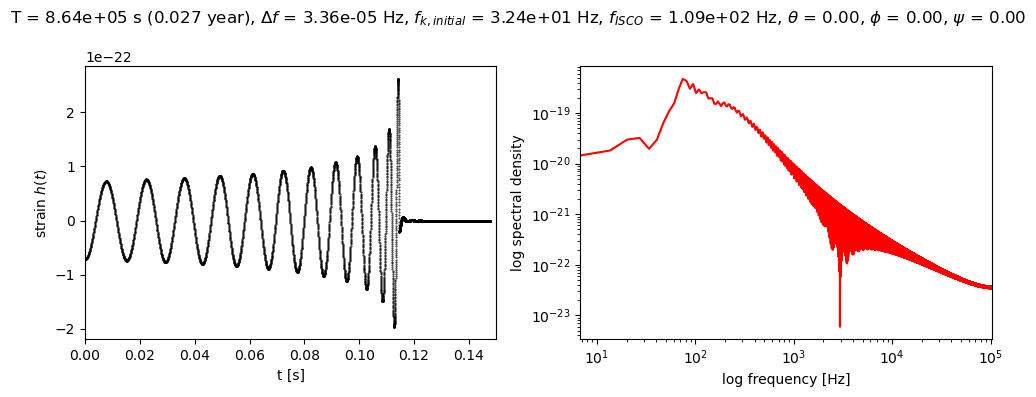

Observing time is: 8.64e+05 s
Time spent in log freq bin is: 3.85e+00 s
delta f is 4.90e+02 Hz
frequency resolution is 1.16e-06 Hz:
Chirping source in LIGO


In [30]:
#merging SBHB at 1 Gpc
merging_SBHB = Binary(M1=10,M2=10,a=400*km,e=0.0,d=1.e9,i=np.pi/2,peri_arg=0,sky_loc=[0,0,0]) 
add_to_big_plot(merging_SBHB,system_array,T=10*day,plot=True,tstart=0,tstop=0.15)

r_periastron (minimum separation): 50.00 km
r_apoastron (maximum separation): 50.00 km
Orbital period: 0.00 s
f kepler: 2.84e+02 Hz
R ISCO: 2.67e+01 km
f ISCO: 7.27e+02 Hz
Chirp mass: 1.31 M_sun
Eccentricity factor F_e: 1.00e+00
Coalescence time: 5.25e+00 periods: 5.86e-10 years (1.85e-02 s)


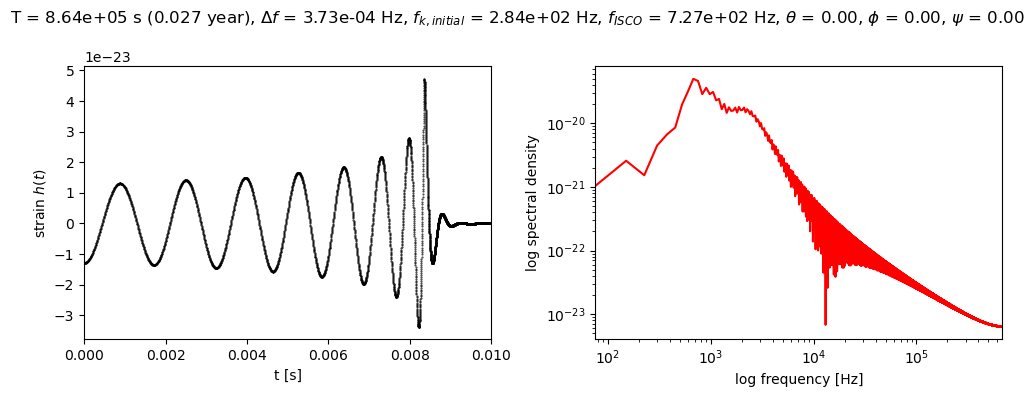

Observing time is: 8.64e+05 s
Time spent in log freq bin is: 1.48e-02 s
delta f is 2.03e+03 Hz
frequency resolution is 1.16e-06 Hz:
Chirping source in LIGO


In [31]:
#merging NS at 1 Gpc
merging_NS = Binary(M1=1.5,M2=1.5,a=50*km,e=0.0,d=1.e9,i=np.pi/2,peri_arg=0,sky_loc=[0,0,0]) 
add_to_big_plot(merging_NS,system_array,T=10*day,plot=True,tstart=0,tstop=0.01)

r_periastron (minimum separation): 1.00 AU
r_apoastron (maximum separation): 1.00 AU
Orbital period: 6.20 hours
f kepler: 4.48e-05 Hz
R ISCO: 1.19e-01 AU
f ISCO: 1.09e-03 Hz
Chirp mass: 870550.56 M_sun
Eccentricity factor F_e: 1.00e+00
Coalescence time: 2.24e+02 periods: 1.58e-01 years (5.00e+06 s)


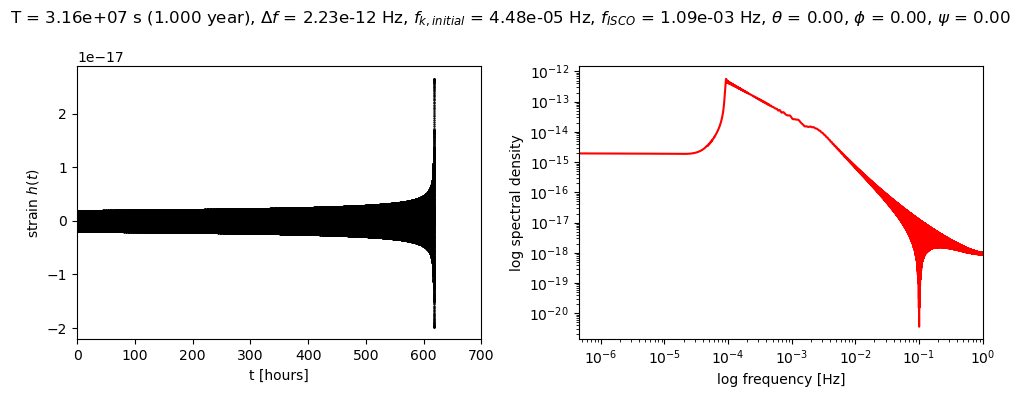

Observing time is: 3.16e+07 s
Time spent in log freq bin is: 3.38e+07 s
delta f is 3.18e-03 Hz
frequency resolution is 3.17e-08 Hz:
Drifting source in LISA


In [33]:
#merging SMBHB at 10 Gpc
merging_SMBHB = Binary(M1=1.e6,M2=1.e6,a=1*AU,e=0.0,d=1.e9,i=np.pi/2,peri_arg=0,sky_loc=[0,0,0]) 
add_to_big_plot(merging_SMBHB,system_array,T=1*yr,plot=True,pbar=False,tstart=0,tstop=700*hour)

In [35]:
#mono black hole binary at 1 Gpc in LISA
mono_SBHB = Binary(M1=100,M2=100,a=5*R_sun,e=0.0,d=1.e3,i=np.pi/2,peri_arg=0,sky_loc=[0,0,0]) 
add_to_big_plot(mono_SBHB,system_array,pbar=True,T=10*day)

r_periastron (minimum separation): 5.00 R_sun
r_apoastron (maximum separation): 5.00 R_sun
Orbital period: 2.20 hours
f kepler: 1.26e-04 Hz
R ISCO: 2.56e-03 R_sun
f ISCO: 1.09e+01 Hz
Chirp mass: 87.06 M_sun
Eccentricity factor F_e: 1.00e+00
Coalescence time: 1.85e+08 periods: 4.64e+04 years (1.46e+12 s)


Evolution Progress: 100%|▉| 173834251222.40964/174010818485.45813 [00:28<00:00, 

Observing time is: 8.64e+05 s
Time spent in log freq bin is: 2.50e+06 s
delta f is 8.02e-07 Hz
frequency resolution is 1.16e-06 Hz:
Monochromatic source in LISA


In [39]:
#mono SMBHB binary at 1 Gpc in PTA
mono_superBig = Binary(M1=1.e9,M2=1.e9,a=1.e-2*parsec,e=0.0,d=100.e9,i=np.pi/2,peri_arg=0,sky_loc=[0,0,0]) 
add_to_big_plot(mono_superBig,system_array,pbar=False,T=30*yr)

r_periastron (minimum separation): 0.01 parsec
r_apoastron (maximum separation): 0.01 parsec
Orbital period: 2.09 years
f kepler: 1.51e-08 Hz
R ISCO: 5.77e-04 parsec
f ISCO: 1.09e-06 Hz
Chirp mass: 870550563.30 M_sun
Eccentricity factor F_e: 1.00e+00
Coalescence time: 1.37e+03 periods: 2.87e+03 years (9.05e+10 s)
Observing time is: 9.47e+08 s
Time spent in log freq bin is: nan s
delta f is 2.89e-10 Hz
frequency resolution is 1.06e-09 Hz:
Monochromatic source in PTA


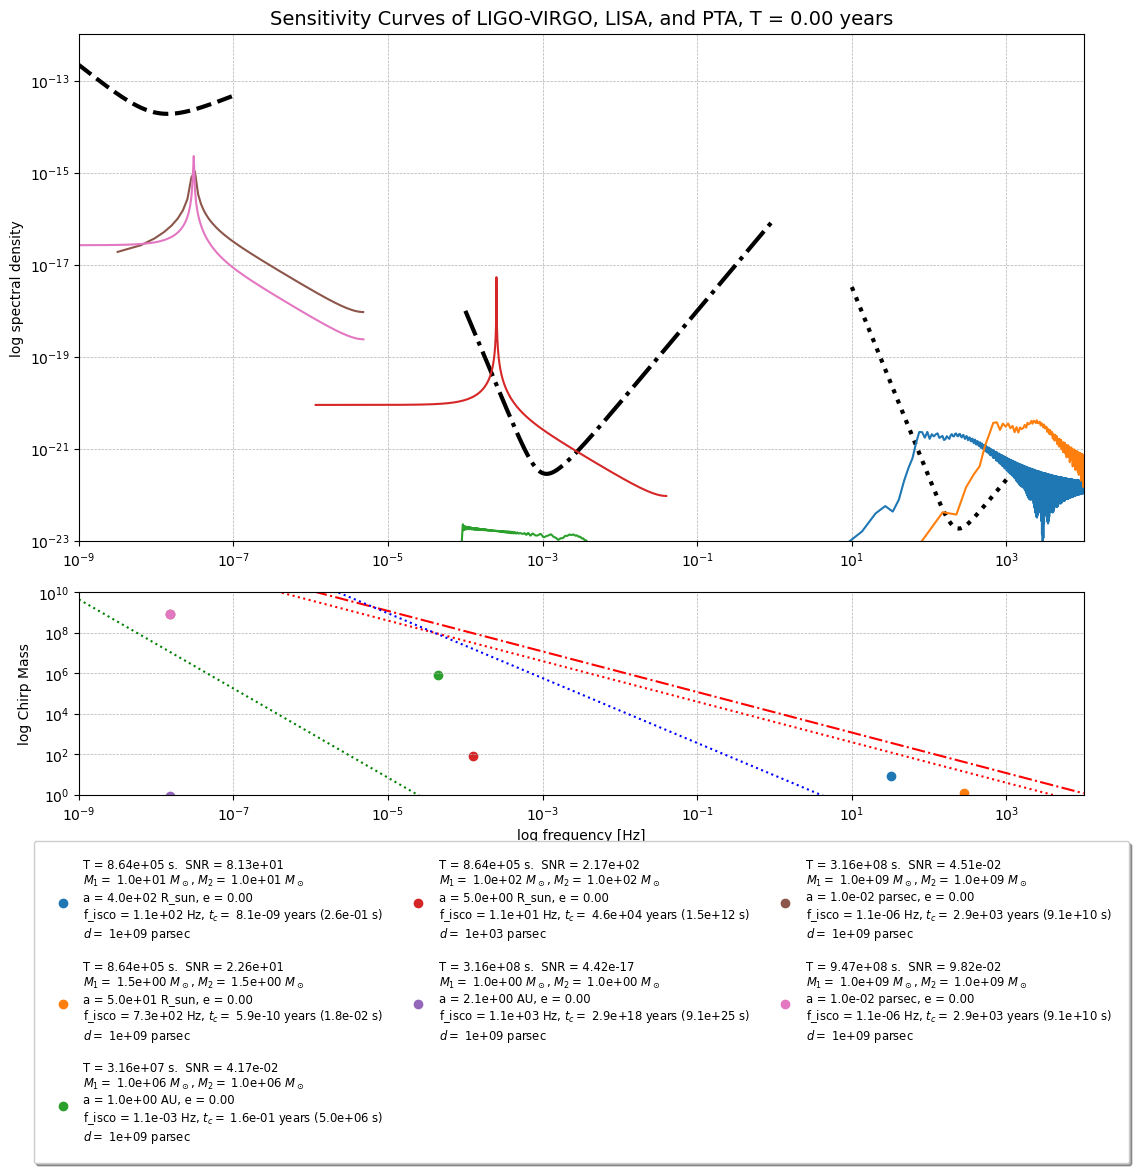

In [204]:
show_big_plot(system_array,T=yr)


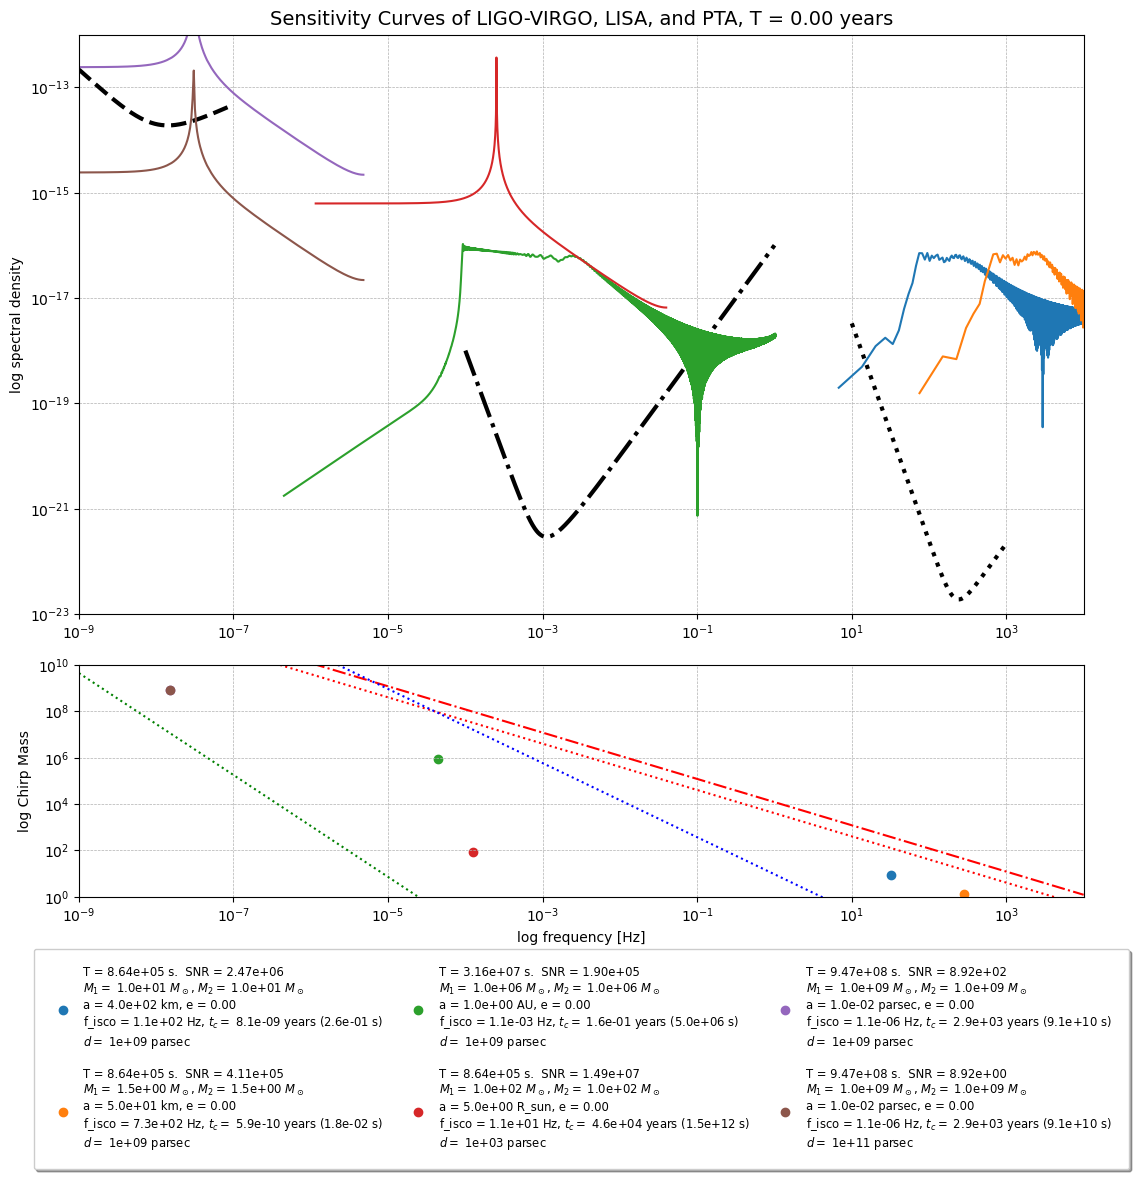

In [40]:
show_big_plot(system_array,T=yr)

In [205]:
#remove_from_big_plot([5],system_array)

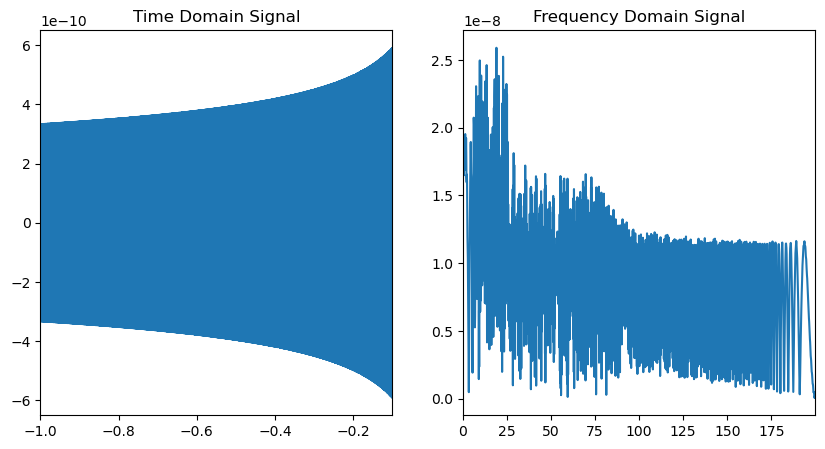

In [362]:
def merger_waveform(binary, t): 
    Omega = binary.Omega * (-t / (binary.t_c)) ** (-3/8)  # Updated to use binary.t_c directly
    f = Omega / (2 * np.pi)
    phase = -2 * ((binary.M_chirp)**(-5/8) * (-t)) ** (5/8)  # Assuming G, c, etc. are in binary
    A_gw = 2 * (binary.M_chirp)**(5/3) / (binary.d) * (np.pi * f) ** (2/3)
    
    h_plus = np.where(t < 0, A_gw * (1 + np.cos(binary.i) ** 2) * np.cos(f * t), 0)
    h_cross = np.where(t < 0, A_gw * (-2 * np.cos(binary.i)) * np.sin(f * t), 0)
    
    return h_plus, h_cross

def h_f(binary, tstart, tstop, sampling_rate):
    dt = 1 / sampling_rate
    t = np.arange(tstart, tstop, dt)
    
    # Generate h_plus over the entire time array
    h_plus, _ = merger_waveform(binary, t)
    
    # FFT of h_plus
    fft_h = np.fft.fft(h_plus)
    N = len(fft_h)
    
    frequencies = np.fft.fftfreq(N, dt)
    fft_magnitude = np.abs(fft_h)
    
    # Only return positive frequencies
    return frequencies[:N//2], fft_magnitude[:N//2]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Time domain plot
t = np.linspace(-1, -0.1, 50000)
ax1.plot(t, merger_waveform(my_binary, t)[0])  # Only plotting h_plus here
ax1.set_xlim(min(t), max(t))
ax1.set_title('Time Domain Signal')

# Frequency domain plot
frequencies, fft_magnitude = h_f(my_binary, -10, -1, 400)
ax2.plot(frequencies, fft_magnitude)
ax2.set_xlim(0, max(frequencies))  # Only plot relevant positive frequencies
ax2.set_title('Frequency Domain Signal')

plt.show()

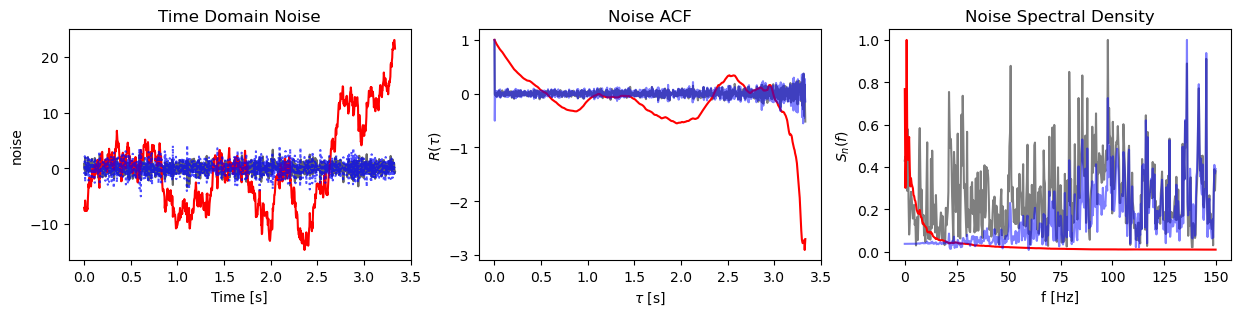

In [16]:
### NOISE POWER SPECTRAL DENSITY ###

sampling_rate = 300  # Sampling rate in Hz
dT = 1 / sampling_rate  # time between samples
N = 1000  # number of samples
T = N*dT # total integration time 

sigma = 1
t = np.linspace(0,T,N)
white_noise = np.random.normal(loc=0, scale=sigma, size=N)
red_noise = np.cumsum(white_noise)  # Cumulative sum of white noise to generate red noise
red_noise -= np.mean(red_noise) 
blue_noise = np.diff(white_noise, n=1)  # Differentiate white noise to emphasize high frequencies
blue_noise = np.append(blue_noise, blue_noise[-1])  # Match original length by appending the last value
blue_noise -= np.mean(blue_noise)


fft_white = np.fft.fft(white_noise) 
frequencies = np.fft.fftfreq(N, dT)[:N//2]  #Compute the corresponding (positive) frequencies
fft_white_magnitude = np.abs(fft_white)[:N//2]  # Take the magnitude (absolute value) of the FFT complex result
fft_red = np.fft.fft(red_noise) 
fft_red_magnitude = np.abs(fft_red)[:N//2]  
fft_blue = np.fft.fft(blue_noise) 
fft_blue_magnitude = np.abs(fft_blue)[:N//2]  

### ACF computed "by hand"
#n_interp = interp1d(t, red_noise, kind='linear', fill_value="extrapolate")
#def ACF(func,tau,T):
#    result, error = quad(lambda t: func(t)*func(t+tau), -T/2, T/2, limit=100, epsabs=1e-8, epsrel=1e-8) #args=(a,)
#    return (1/T)*result
#ACF_array = [] 
#for tau in t: 
#    ACF_array.append(ACF(n_interp,tau,T))

### Faster Autocorrelation using FFT ###
# Autocorrelation can be computed using the FFT convolution
acf_white = fftconvolve(white_noise, white_noise[::-1], mode='full')  # FFT-based convolution for ACF
acf_white = acf_white[N-1:] / np.arange(N, 0, -1)  # Normalize by the number of points
acf_red = fftconvolve(red_noise, red_noise[::-1], mode='full')  # FFT-based convolution for ACF
acf_red = acf_red[N-1:] / np.arange(N, 0, -1)  # Normalize by the number of points
acf_blue = fftconvolve(blue_noise, blue_noise[::-1], mode='full')  # FFT-based convolution for ACF
acf_blue = acf_blue[N-1:] / np.arange(N, 0, -1)  # Normalize by the number of points


fft_acf_white = np.fft.fft(acf_white) 
fft_acf_white_magnitude = np.abs(fft_acf_white)[:N//2]  
fft_acf_red = np.fft.fft(acf_red) 
fft_acf_red_magnitude = np.abs(fft_acf_red)[:N//2]  
fft_acf_blue = np.fft.fft(acf_blue) 
fft_acf_blue_magnitude = np.abs(fft_acf_blue)[:N//2]  



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios': [1, 1,1]})

ax1.plot(t, white_noise, c='black',alpha=0.6) 
ax1.plot(t, red_noise, c='red')
ax1.plot(t, blue_noise, c='blue', linestyle=':',alpha=0.7) 
ax1.set_title("Time Domain Noise")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("noise")

ax2.plot(t, np.array(acf_white)/max(acf_white), c='black',alpha=0.5) 
ax2.plot(t, np.array(acf_red)/max(acf_red), c='red') 
ax2.plot(t, np.array(acf_blue)/max(acf_blue), c='blue',alpha=0.5) 
ax2.set_title("Noise ACF")
ax2.set_xlabel("$\\tau$ [s]")
ax2.set_ylabel("$R(\\tau)$")

#ax3.plot(frequencies, 2*fft_white_magnitude/max(fft_white_magnitude)/T)
ax3.plot(frequencies, np.array(fft_acf_white_magnitude)/max(fft_acf_white_magnitude),c='black',alpha=0.5)
ax3.plot(frequencies, np.array(fft_acf_red_magnitude)/max(fft_acf_red_magnitude),c='red')
ax3.plot(frequencies, np.array(fft_acf_blue_magnitude)/max(fft_acf_blue_magnitude),c='blue',alpha=0.5)
ax3.set_title("Noise Spectral Density")
ax3.set_xlabel("f [Hz]")
ax3.set_ylabel("$S_n(f)$")

plt.show()

h_0 is 1.000000
n0/rad(N) is 0.632456


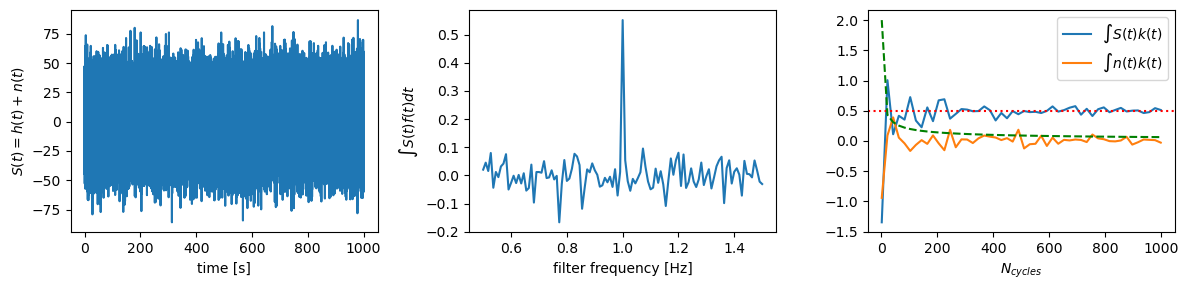

In [39]:
### MATCH FILTERING ###

A_signal = 10
freq_signal = 1
P_signal = 1 / freq_signal
sigma_noise = 20

# Signal function
def h(t):
    return A_signal * np.sin(2 * np.pi * freq_signal * t)

# Generate time-dependent white noise
def n(t):
    return np.random.normal(0, sigma_noise, size=t.shape)

# Noisy signal
def S(t):
    return h(t) + n(t)

# Matched filter
def filter(t, A_filter, freq_filter):
    return A_filter * np.sin(2 * np.pi * freq_filter * t)

# Parameters
T = 1000 * P_signal
dt = 0.01 * P_signal  # Time step

freq_filter = np.linspace(0.5, 1.5, 111)
integral_match_filter = []

t = np.arange(0, T, dt)
for f in freq_filter:
    integral_match_filter.append(np.sum(S(t) * filter(t,A_signal,f)) * dt / T)  #quad not working

h0 = A_signal
n0 = sigma_noise
n_cycles = T/P_signal
print("h_0 is %f" %h0)
print("n0/rad(N) is %f" %(n0/np.sqrt(n_cycles)))


# Parameters
T_array = np.linspace(P_signal,1000*P_signal)
dt = 0.01 * P_signal 
integral_noise = []
integral_signal = []

for i in range(len(T_array)):
    t = np.arange(0, T_array[i], dt)
    integral_noise.append(np.sum(n(t) * filter(t,A_signal,freq_signal)) * dt / T_array[i])
    integral_signal.append(np.sum(S(t) * filter(t,A_signal,freq_signal)) * dt / T_array[i])



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 1,1]})

t = np.arange(0,T,dt)
ax1.plot(t,S(t))
ax1.set_xlabel("time [s]")
ax1.set_ylabel("$S(t)=h(t)+n(t)$")

ax2.plot(freq_filter,integral_match_filter)
ax2.set_xlabel("filter frequency [Hz]")
ax2.set_ylabel("$\int S(t)f(t)dt$")

N_cycles = T_array/P_signal
ax3.plot(N_cycles,integral_signal,label="$\\int S(t)k(t)$")
ax3.axhline(y = h0**2/2, c = 'red', linestyle = ':')
ax3.plot(N_cycles,integral_noise,label="$\\int n(t)k(t)$")
ax3.plot(N_cycles,h0*n0/np.sqrt(T_array/dt), c = 'green', linestyle = '--')
#ax3.set_xlim(100,1000)
ax3.set_xlabel("$N_{cycles}$")
#ax3.set_ylabel("$\int S(t)f(t)dt$")
ax3.legend()

plt.tight_layout()
plt.show()


In [50]:
### Wiener filter ###

## returns complex wiener function of f (defined from -inf to +inf)

def Wiener_filter(h,params,Sn,sampling_rate,T): 

    dT = 1 / sampling_rate  
    N = int(T/dT)

    t = np.linspace(0,T,N)
    signal = h(t,params)

    fft_signal = np.fft.fft(signal) 
    frequencies = np.fft.fftfreq(N, dT) 
    
    fft_signal_func = interp1d(frequencies, fft_signal, kind='linear', fill_value="extrapolate")
    
    def wiener_filter(f):
        return fft_signal_func(f) / Sn(f)  
    
    return wiener_filter
#####



def SNR(h_filter, params, Sn, sampling_rate, T):

    dT = 1 / sampling_rate  
    N = int(T/dT)
    t = np.linspace(0, T, N)
    h_signal = h_filter(t, params)

    """
    This 
    """
    
    # Compute FFT
    fft_signal = np.fft.fft(h_signal) 
    frequencies = np.fft.fftfreq(N, dT)

    # Only take the positive frequencies and corresponding FFT values
    positive_freqs = frequencies[:N // 2]  
    fft_signal_positive = fft_signal[:N // 2]  
    
    # Interpolate FFT values
    fft_signal_func = interp1d(positive_freqs, fft_signal_positive, kind='linear', fill_value="extrapolate")

    # Get the Wiener filter function
    wiener_filter = Wiener_filter(h_filter, params, Sn, sampling_rate, T)

    # Calculate the expected value of the signal (S_exp_value)
    S_exp_value = quad(
        lambda f: fft_signal_func(f) * np.conjugate(wiener_filter(f)), 
        0, np.max(positive_freqs)  # Limit integration to positive frequencies
    )[0]

    # Calculate the expected value of the noise (N_exp_value)
    N_exp_value = np.sqrt(
        quad(
            lambda f: 1/2 * Sn(f) * (wiener_filter(f) * np.conjugate(wiener_filter(f))), 
            0, np.max(positive_freqs)  # Limit integration to positive frequencies
        )[0]
    )
    
    # Return the SNR
    return np.abs(S_exp_value) / N_exp_value


def SNR_white(h_filter, params, Sn, sampling_rate, T):

    dT = 1 / sampling_rate  
    N = int(T/dT)
    t = np.linspace(0, T, N)
    h_signal = h_filter(t, params)
    
    # Compute FFT
    fft_signal = np.fft.fft(h_signal) 
    frequencies = np.fft.fftfreq(N, dT)  # Full frequency range
    positive_freqs = frequencies[:N // 2]  # Only positive frequencies
    fft_signal_positive = fft_signal[:N // 2]  # Only positive frequencies

    # Interpolate on the complex FFT values, not just magnitudes, because the SNR calculation needs the phase information as well.
    fft_signal_func = interp1d(positive_freqs, fft_signal_positive, kind='linear', fill_value="extrapolate")

    # Calculate the SNR
    SNR_squared = 4 * quad(
        lambda f: np.abs(fft_signal_func(f)**2) / Sn(f),
        0, np.max(positive_freqs)  # Only integrate over the range of available frequencies
    )[0]
    
    return np.sqrt(SNR_squared)

    
    ####
    #result, error = quad(lambda freq: fft_signal_func(freq)/Sn(freq), 0, np.infty, limit=50, epsabs=1e-8, epsrel=1e-8)
    #SNR = 2*np.sqrt(result)
    
    #return SNR

In [206]:
A_signal = 1.e-23
freq_signal = 1.e-2
phi_0_signal = np.pi
P_signal = 1 / freq_signal

# Signal function
def h(t,params):
    return A_signal * np.sin(2 * np.pi * freq_signal * t + phi_0_signal)
def Sn(f):
    return 1.e-42

#params = [1,1]
sampling_rate = 1
T = 1.e5
params = 0

print(SNR(h, params, Sn, sampling_rate, T))
print(SNR_white(h, params, Sn, sampling_rate, T))

#f = np.linspace(0,100)
#Wiener_filter(h,params,Sn,sampling_rate,T)

#print(Wiener_filter(h,params,Sn,sampling_rate,T)(f))
#print(Wiener_filter(h,params,Sn,sampling_rate,T)(f).conjugate())

TypeError: object of type 'function' has no len()

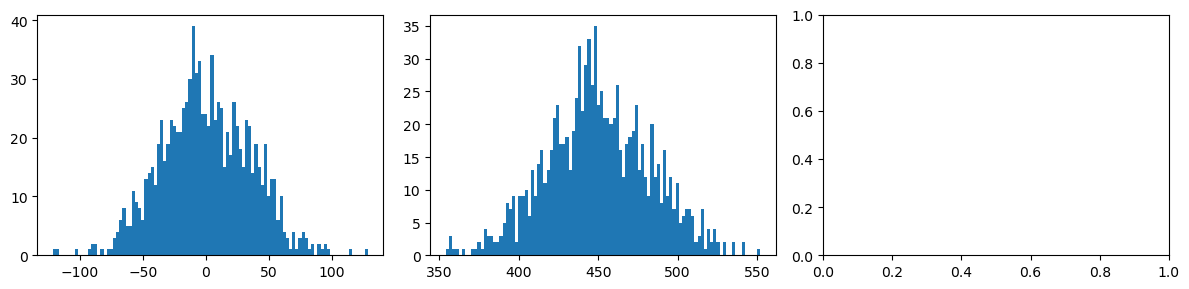

In [15]:
### DETECTION STATISTICS ###

A_signal = 30
freq_signal = 1
P = 1 / freq_signal

B = 100
sigma = 0.5

# Signal function
def h(t):
    return A_signal * np.sin(2 * np.pi * freq_signal * t)

# Generate time-dependent noise
def n(t):
    return B * np.random.normal(0, sigma, size=t.shape)

# Noisy signal
def S(t):
    return h(t) + n(t)

# Matched filter
def filter(t, A, freq):
    return A * np.sin(2 * np.pi * freq * t)

# Parameters
T = 10 * P
dt = 0.01 * P  # Time step
freq_filter = 1

integral_no_signal = []
integral_signal = []
t = np.arange(0, T, dt)
for _ in range(1000):
    integral_no_signal.append(np.sum(n(t) * filter(t,A_signal,freq_filter)) * dt / T)
    integral_signal.append(np.sum(S(t) * filter(t,A_signal,freq_filter)) * dt / T)

#quad(lambda t: 1/T[i] * S(t)*h(t), 0, T[i])[0]
#quad not working

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 1,1]})

ax1.hist(integral_no_signal,100)
ax2.hist(integral_signal,100)
#ax1.set_xlabel("time [s]")
#ax1.set_ylabel("S(t)=h(t)+n(t)")

#ax2.plot(freq_filter,integral)
#ax2.set_xlabel("filter frequency [Hz]")
#ax2.set_ylabel("$\int S(t)f(t)dt$")

#ax3.plot(T_array/P,integral_12)
#ax3.plot(T_array/P,integral_2)
#ax3.set_xlabel("cycles integrated")
#ax3.set_ylabel("$\int S(t)f(t)dt$")

plt.tight_layout()

In [ ]:

        #n_cycles
        #print(len(frequency_kepler))
        #print(len(t))
        #frequency_kepler = np.array(frequency_kepler)*s_IU
        #interp_func = interp1d(frequency_kepler, t, kind='linear', fill_value="extrapolate") 
        #dt_df = derivative(interp_func, frequencies, dx=1e-6)

        
        #n_cycles = dt_df*frequencies**2

        ## n cycles: the time spent in each frequency bin ##
        #frequency_kepler = 1/(2*np.pi) * np.sqrt(self.M/separation**3)*s_IU  #in Hz   #includes also ringdown      
        #dt_arr = np.diff(t)/s_IU
        #dt_arr = np.insert(dt_arr, 0, dt_arr[0])  # Prepend the first difference

        #bin_indices = np.digitize(frequency_kepler, frequencies) - 1  
        #bin_indices = np.clip(bin_indices, 0, len(frequencies) - 1)  # Clamp indices to valid range
                
        #dt_sums = np.zeros(len(frequencies))
        #for i, bin_index in enumerate(bin_indices):
        #    if bin_index >= 0 and bin_index < len(frequencies) - 1:  
        #        dt_sums[bin_index] += dt_arr[i]      

        #### n_cycles = dt_sums/df * frequencies**2
        #### n_cycles = dt_sums/t_obs
        #n_cycles = dt_sums * frequencies

        #print(frequencies)
        #print(frequency_kepler)
        #print(n_cycles)

In [ ]:
        #freq_times, frequencies = extract_frequencies(np.array(t), np.array(h_plus_arr))
        #f_of_t = interp1d(freq_times, frequencies, kind='linear', fill_value="extrapolate")  #plus,cross??

        #A_gw = 2*self.M_chirp**(5/3)/(c_IU**4*self.d)
    
        #phase_c_plus = np.arcsin(h_plus_arr[-1]/( (1+np.cos(self.i)**2) * A_gw * (np.pi*f_of_t(t[-1]))**(2/3)) )
        #phase_c_cross = np.arccos(h_cross_arr[-1]/( (-2*np.cos(self.i)) *A_gw * (np.pi*f_of_t(t[-1]))**(2/3)))
        
        #phase_plus = phase_c_plus #- self.argument_of_periastron
        #phase_cross = phase_c_cross #- self.argument_of_periastron

        #while t[-1] < tstop and f_of_t(t[-1]) < f_ringdown:    
            #phase += 2 * np.pi * f_of_t((t[-1] + t[-1] + dt) / 2) * dt
            #phase_plus += quad(lambda t_: 2*np.pi * f_of_t(t_),t[-1],t[-1]+dt)[0]
            #phase_cross += quad(lambda t_: 2*np.pi * f_of_t(t_),t[-1],t[-1]+dt)[0]
            #h_plus_arr.append((1+np.cos(self.i)**2)*A_gw*(np.pi*f_of_t(t[-1]))**(2/3)*np.cos(phase_plus))
            #h_cross_arr.append((-2*np.cos(self.i))*A_gw*(np.pi*f_of_t(t[-1]))**(2/3)*np.sin(phase_cross))
            #t.append(t[-1]+dt)
            #R1.append(R1[-1])
            #R2.append(R2[-1])
            #V1.append(V1[-1])
            #V2.append(V2[-1])
            #r.append(r[-1])

        #while t[-1] < tstop: 
    
            #phase_plus += 2*np.pi*f_ringdown*dt
            #h_plus_arr.append((1+np.cos(self.i)**2)*A_gw*(np.pi*f_ringdown)**(2/3) * np.exp(-2 * f_ringdown * t[-1] / Q) * np.cos(phase_plus))
            #h_cross_arr.append((-2*np.cos(self.i))*A_gw*(np.pi*f_ringdown)**(2/3) * np.exp(-2 * f_ringdown * t[-1] / Q) * np.sin(phase_plus))
            #R1.append(R1[-1])
            #R2.append(R2[-1])
            #V1.append(V1[-1])
            #V2.append(V2[-1])
            #r.append(r[-1])
            #t.append(t[-1]+dt)



#####

#other approach

        #f_of_t = instantaneous_freq(t,h_plus_arr)
        #phase_c = last_phase(t,h_plus_arr)
        #A = h_plus_arr[-1]/np.cos(phase_c)
        #dt = np.min(np.diff(t))




In [ ]:
def v_IU(M_cgs, r_cgs, v_cgs):
    return np.sqrt(r_cgs/(G*M_cgs))*v_cgs

def t_IU(M_cgs, r_cgs, t_cgs):
    return t_cgs/(np.sqrt(r_cgs/(G*M_cgs))*r_cgs)

#v_conversion = v_IU(M_sun,AU,26.22*10**5)
AU_IU = 1
parsec_IU = parsec/AU
R_sun_IU = R_sun/AU
km_IU = 1.e5/AU
yr_IU = t_IU(M_sun,AU,3.156*10**7)
day_IU = t_IU(M_sun,AU,86400)
hour_IU = t_IU(M_sun,AU,3600)
s_IU = t_IU(M_sun,AU,1)
c_IU = v_IU(M_sun,AU,c)
cm_s_IU = v_IU(M_sun,AU,1)


#print("26.22 km/s expressed in internal units is: %f" % v_conversion)
print("1 year expressed in internal units is: %f" % yr_IU)
print("1 s expressed in internal units is: %e" % s_IU)
print("c expressed in internal units is: %f" % c_IU)
print("1 cm/s expressed in internal units is: %e" % cm_s_IU)

In [ ]:


def instantaneous_freq(t,h):
    # Resample the time series data (t, h) to have equal timesteps
    dt = np.min(np.diff(t))  # smallest timestep in the original data
    t_uniform = np.arange(t[0], t[-1], dt) #_uniform
    h_interp = interp1d(t, h, kind='linear', fill_value="extrapolate")  
    h_resampled = h_interp(t_uniform)
    
    analytic_h = hilbert(h_resampled)
    amplitude_envelope = np.abs(analytic_h)
    #last_amplitude = amplitude_envelope[-1]
    instantaneous_phase = np.unwrap(np.angle(analytic_h))
    #last_phase = instantaneous_phase[-1]
            
    #Differentiate the phase to get the instantaneous frequency
    instantaneous_freq = np.diff(instantaneous_phase) / (2.0 * np.pi * dt)
    freq_interp = interp1d(t_uniform[:-1], instantaneous_freq, fill_value="extrapolate", kind='cubic')

    return freq_interp


def last_phase(t,h):
    analytic_h = hilbert(h)
    amplitude_envelope = np.abs(analytic_h)
    #last_amplitude = amplitude_envelope[-1]
    instantaneous_phase = np.unwrap(np.angle(analytic_h))
    return instantaneous_phase[-1]